In [2]:
import numpy as np
import gdal
import matplotlib as mpl
import pandas as pd
import bz2
from netCDF4 import Dataset
import h5py
import pylab as plt

This is just one sample dataset representing the estimation at 2016-06-27 15 UTC

In [3]:
f = h5py.File('data/S-LSA_-HDF5_LSASAF_MSG_DSSF_SAme_201606271500')

DSSF files are HDF5 files with two groups: DSSF and DSSF_Q_FLAG

In [4]:
print(f.keys())

[u'DSSF', u'DSSF_Q_Flag']


With h5py we can read files and get numpy arrays directly

In [7]:
f['/'].attrs['SENSING_START_TIME']

'201606271500'

In [10]:
for a in f['/'].attrs:
    print(a)

SAF
CENTRE
ARCHIVE_FACILITY
PRODUCT
PARENT_PRODUCT_NAME
SPECTRAL_CHANNEL_ID
PRODUCT_ALGORITHM_VERSION
CLOUD_COVERAGE
OVERALL_QUALITY_FLAG
ASSOCIATED_QUALITY_INFORMATION
REGION_NAME
COMPRESSION
FIELD_TYPE
FORECAST_STEP
NC
NL
NOMINAL_PRODUCT_TIME
SATELLITE
INSTRUMENT_ID
INSTRUMENT_MODE
IMAGE_ACQUISITION_TIME
ORBIT_TYPE
PROJECTION_NAME
NOMINAL_LONG
NOMINAL_LAT
CFAC
LFAC
COFF
LOFF
START_ORBIT_NUMBER
END_ORBIT_NUMBER
SUB_SATELLITE_POINT_START_LAT
SUB_SATELLITE_POINT_START_LON
SUB_SATELLITE_POINT_END_LAT
SUB_SATELLITE_POINT_END_LON
SENSING_START_TIME
SENSING_END_TIME
PIXEL_SIZE
GRANULE_TYPE
PROCESSING_LEVEL
PRODUCT_TYPE
PRODUCT_ACTUAL_SIZE
PROCESSING_MODE
DISPOSITION_FLAG
TIME_RANGE
STATISTIC_TYPE
MEAN_SSLAT
MEAN_SSLON
PLANNED_CHAN_PROCESSING
FIRST_LAT
FIRST_LON
NB_PARAMETERS


In [9]:
for a in f['/DSSF'].attrs:
    print(a)

CLASS
PRODUCT
PRODUCT_ID
N_COLS
N_LINES
NB_BYTES
SCALING_FACTOR
OFFSET
MISSING_VALUE
UNITS
CAL_SLOPE
CAL_OFFSET


In [11]:
print(f['/DSSF'].attrs['SCALING_FACTOR'])

10.0


In [12]:
for a in f['DSSF_Q_Flag'].attrs:
    print(a)

CLASS
PRODUCT
PRODUCT_ID
N_COLS
N_LINES
NB_BYTES
SCALING_FACTOR
OFFSET
MISSING_VALUE
UNITS
CAL_SLOPE
CAL_OFFSET


In [13]:
# [()] forces file reading
dssf = f['DSSF'][()]
dssf_q = f['DSSF_Q_Flag'][()]

# axes are swapped
#np.swapaxes(dssf, 1, 0)
dssf.shape

(1511, 701)

Let's take a quick look at the original data.

Unit of measurement is W/m2 and values are scaled by 10.

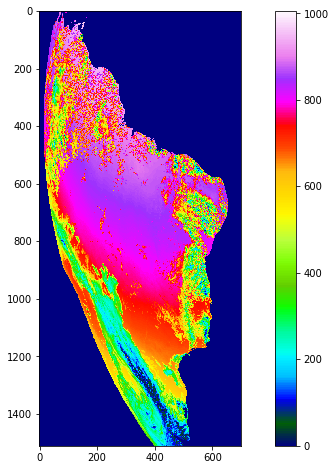

In [19]:
dssf_scaling_factor = f['DSSF'].attrs['SCALING_FACTOR']

fig = mpl.pyplot.gcf()
fig.set_size_inches(12, 8)
plt.imshow(dssf/dssf_scaling_factor, 'gist_ncar')
plt.colorbar()
plt.show()

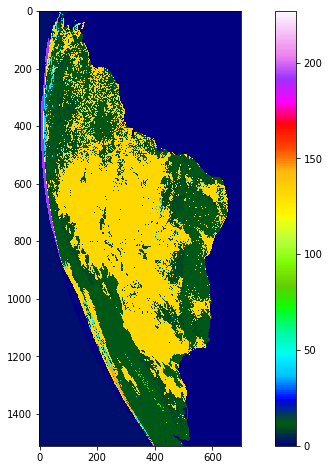

In [18]:
dssf_q_scaling_factor = f['/DSSF_Q_Flag'].attrs['SCALING_FACTOR']

fig = mpl.pyplot.gcf()
fig.set_size_inches(12, 8)
plt.imshow(dssf_q/dssf_q_scaling_factor, 'gist_ncar')
plt.colorbar()
plt.show()

Eumetsat LSA SAF distributes auxiliary data sets for registered users.
We have files for latitude, longitude and elevation data

In [6]:
lon = h5py.File('data/HDF5_LSASAF_MSG_LON_SAme_4bytesPrecision', 'r')['LON'][()]/10000.
lat = h5py.File('data/HDF5_LSASAF_MSG_LAT_SAme_4bytesPrecision',  'r')['LAT'][()]/10000.

elevation = h5py.File('data/HDF5_LSASAF_USGS_DEM_SAme', 'r')['DEM'][()].ravel()

Read stations coordinates

In [7]:
stations = pd.read_csv('data/features/station/stations.csv')
stations.head()

id                 name       lat       lon  elevation
0  25134848             Antonina -25.24341 -48.75248       60.0
1  23515154            Apucarana -23.51750 -51.53020      746.0
2  24235332  Assis Chateaubriand -24.38860 -53.54110      450.0
3  25354852       BR 277 - KM 41 -25.57940 -48.88110      374.0
4  23005002              Cambará -23.00250 -50.03620      450.0

Harvesine formula to calculate distances between two points over a sphere surface

In [8]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.power(np.sin(dlat/2), 2) + np.cos(lat1) * np.cos(lat2) * np.power(np.sin(dlon/2), 2)
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

For each station, create a distance array based on the lon and lat arrays from auxiliary data, using the harvesine formula

In [9]:
lon1 = lon.ravel()
lat1 = lat.ravel()

distances = {}

for idx, row in stations.iterrows():
    lon2 = np.full(lon1.size, row.lon)
    lat2 = np.full(lat1.size, row.lat)
    distances[row.id] = haversine(lon1, lat1, lon2, lat2)

In [10]:
stations[stations['id'] == 25264916]

id      name       lat       lon  elevation
14  25264916  Curitiba -25.44817 -49.23033      935.0

Create a new dataframe with station ids, names, coordinates, station elevations, and dssf pixels indexes, elevations, and distances in km from pixels to station locations

In [12]:
from __future__ import division

df_dssf_stations = pd.DataFrame()

for k in distances.keys():
    idx = np.argmin(distances[k])
    
    j = idx // dssf.shape[1] # integer division
    i = idx - (j * dssf.shape[1])
    
    e = elevation[idx]
    s = stations[stations['id'] == k]
    
    # check if i and j index references same values in DSSF array using idx
    # print(dssf[j][i]/10)
    # print(dssf.ravel()[idx]/10)
    
    data = {'station_id': k, 
         'station_name': s.name,
         'station_lon': s.lon, 
         'station_lat': s.lat, 
         'station_elevation': s.elevation,
         'dssf_lon': lon1[idx],
         'dssf_lat': lat1[idx],
         'dssf_i': i,
         'dssf_j': j,
         'dssf_index': idx,
         'dssf_elevation': e,
         'dssf_distance': distances[k][idx]}
    
    
    row = pd.DataFrame(data)
    df_dssf_stations = pd.concat([df_dssf_stations, row])

Set desired columns order and station ID as index

In [13]:
ordered_columns = [
    'station_id', 
    'station_name', 
    'station_lon',
    'station_lat',
    'station_elevation',
    'dssf_lon',
    'dssf_lat',
    'dssf_i',
    'dssf_j',
    'dssf_index',
    'dssf_elevation',
    'dssf_distance']

df_dssf_stations = df_dssf_stations[ordered_columns]
df_dssf_stations.set_index(['station_id'])

station_name  station_lon  station_lat  \
station_id                                                           
25134848                        Antonina    -48.75248    -25.24341   
25315329                    Salto Caxias    -53.49450    -25.52070   
25474946                            Lapa    -49.75980    -25.78170   
24205037                  Telêmaco Borba    -50.61060    -24.33900   
25534852                       Paranaguá    -48.52960    -25.53780   
25564936                           REPAR    -49.36360    -25.56270   
25415305                   Dois Vizinhos    -53.09527    -25.69906   
23235338                        Icaraíma    -53.63593    -23.39038   
24185355                        Palotina    -53.90080    -24.31290   
25654927         Fazenda Gralha Azul-PUC    -49.27852    -25.65457   
25115408            São Miguel do Iguaçu    -54.25460    -25.35280   
25264913                        Curitiba    -49.23060    -25.44869   
23515154                       Apucarana    -51.53020    -23.51750   
25264916                        Curitiba    -49.23033    -25.44817   
24035222                    Campo Mourão    -52.38654    -24.08543   
23275159                         Maringá    -51.98810    -23.44830   
25135001                    Ponta Grossa    -50.15240    -25.01370   
25215130                      Guarapuava    -51.49350    -25.38450   
25275035              Fernandes Pinheiro    -50.58390    -25.45320   
24134940                     Jaguariaiva    -49.67700    -24.22690   
23765018                          Ibaiti    -50.18057    -23.77334   
25324831                       Guaratuba    -48.58049    -25.84536   
23395232                        Cianorte    -52.54760    -23.65220   
24535333                        Cascavel    -53.55470    -24.88450   
25835036               São Mateus do Sul    -50.36899    -25.83560   
23245155                         Maringa    -51.93283    -23.40536   
25174828    Reserva Natural Salto Morato    -48.28810    -25.17790   
24535213                        Palmital    -52.21860    -24.86440   
26445235                     Clevelândia    -52.34874    -26.41720   
26055305               Francisco Beltrão    -53.05080    -26.05930   
...                                  ...          ...          ...   
23005002                         Cambará    -50.03620    -23.00250   
24505420                    Santa Helena    -54.31030    -24.91680   
23385294                   Cidade Gaúcha    -52.93191    -23.35916   
24474959                          Castro    -49.99927    -24.78695   
26145103                União da Vitória    -51.06660    -26.23330   
23435346                        Planalto    -53.74792    -25.72186   
25294819                     Ilha Do Mel    -48.32604    -25.49452   
23185109                        Londrina    -51.16470    -23.35950   
25254905                         Pinhais    -49.12990    -25.39070   
25335129                      Entre Rios    -51.48840    -25.54590   
24385115                Cândido de Abreu    -51.24520    -24.63210   
23445317                        Umuarama    -53.30710    -23.75030   
25315301                    Salto Osorio    -53.03030    -25.52170   
25385157                          Pinhão    -51.96250    -25.64944   
26055139                    Foz do Areia    -51.66790    -26.00370   
25354852                  BR 277 - KM 41    -48.88110    -25.57940   
24115301                         Goioerê    -53.03059    -24.15846   
26285158                          Palmas    -51.97620    -26.46820   
24045415                          Guaira    -54.26130    -24.06670   
26075241                     Pato Branco    -52.65140    -26.12290   
23245034                     Nova Fátima    -50.57774    -23.41528   
24325101              Mal.Candido Rondon    -54.01925    -24.53330   
26445135                General Carneiro    -51.35367    -26.39847   
25424883                        Morretes    -48.80868    -25.50894   
22375289               Diamante do Nor

Export the results as CSV for utilization in DSSF feature extraction

In [14]:
df_dssf_stations.to_csv('data/features/station/station_dssf.csv', mode='w', index=False)

In [15]:
lon_diffs = np.diff(lon)
lon_diffs = np.absolute(lon_diffs)
lon_diffs = lon_diffs[lon_diffs > 0]
lon_res = np.min(lon_diffs)

In [16]:
lat_diffs = np.diff(lat, axis=0)
lat_diffs = np.absolute(lat_diffs)
lat_diffs = lat_diffs[lat_diffs > 0]
lat_res = np.min(lat_diffs)

In [17]:
print(lon_res, lat_res)

(0.035399999999995657, 0.027999999999999581)


In [18]:
from country_bounding_boxes import country_bounding_boxes

In [19]:
coords = country_bounding_boxes['BR']
coords

('Brazil', (-73.9872354804, -33.7683777809, -34.7299934555, 5.24448639569))

In [20]:
dssf.shape

(1511, 701)

In [21]:
elevation.max()

5873

**The code bellow is not working. Just a reminder on the initial steps to reproject the original data.**

In [22]:
from mpl_toolkits.basemap import Basemap

In [23]:
fig = plt.figure(figsize=(10,10))
m = Basemap(projection='cyl', 
            llcrnrlon=coords[1][0],
            llcrnrlat=coords[1][1],
            urcrnrlon=coords[1][2],
            urcrnrlat=coords[1][3],
            resolution='i')

x, y = m(lon.ravel(), lat.ravel())

m.drawcoastlines()

In [24]:
cs = m.imshow(lon, lat, dssf)

/discolocal/mestrado/solar_radiation_regression/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/discolocal/mestrado/solar_radiation_regression/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3303: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


ValueError: 'norm' must be an instance of 'mcolors.Normalize'

In [ ]:
plt.show()